## Demo Class Camera

In [7]:
import matplotlib.pylab as plt
import numpy as np
# from cv2 import putText,imencode,FONT_HERSHEY_SIMPLEX,LINE_4,resize, Canny, addWEight
import cv2
import time
import threading
import os
# append system.path with the folder containing basisklassen_cam,.py
import sys
sys.path.append('./../Software')
from basisklassen_cam import Camera
import ipywidgets as widgets
from IPython.display import display

In [ ]:
Camera?

### OpenCV only

60.0


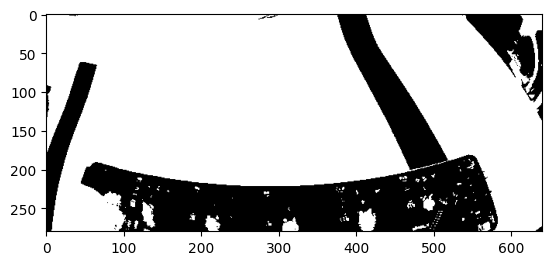

In [8]:
import cv2
vc = cv2.VideoCapture(0)
ret,frame = vc.read()
frame = cv2.flip(frame,-1)
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
threshold=60
ret,frame = cv2.threshold(frame,threshold,1,cv2.THRESH_BINARY)   # gibt threshold und Resultat zurück
frame = frame[200:480,0:640].copy()
print(ret)
plt.imshow(frame, cmap='gray')



In [ ]:
imgTemplate = frame[100:170,50:570].copy()
# threshold=10
# ret,imgTemplate = cv2.threshold(imgTemplate,threshold,1,cv2.THRESH_BINARY)   # gibt threshold und Resultat zurück
plt.imshow(imgTemplate,cmap='gray')
print('Template',type(imgTemplate),imgTemplate.shape)




In [ ]:
res = cv2.matchTemplate(frame, imgTemplate,cv2.TM_SQDIFF) 
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
print(min_val, max_val, min_loc, max_loc)

top_left = min_loc

#-------------------------
# Zeichnen der Boundary Box
ht,wt = imgTemplate.shape
bottom_right = (top_left[0] + wt, top_left[1] + ht)
img3=cv2.rectangle(frame.copy(), top_left, bottom_right, (255,0,0), 3)
#img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2RGB)

plt.imshow(img3, cmap='gray')
print(top_left)
print(bottom_right)



In [9]:
vc.release()

In [ ]:
# Verwendung der Kamera uas basisklassen_cam.py
cam = Camera(width=64*3, height=48*3) # Erstellen der Kamera
print(cam.get_size())

image = widgets.Image()            # Erstellen eines Widgets Image
display(image)                     # Anzeigen des Widgets

# Schleife aktualisiert Image
while True:
    frame = cam.get_frame()
    _, jpg = cv2.imencode('.jpeg', frame)
    image.value = jpg.tobytes()

In [4]:
# Widget erlaubt die Anzeige eines Bildes/Live-Streams in einer Output-Zelle
# Dem Widget werden zwei Funktionen übergeben. Diese Funktionen müssen Numpy-Arrays zurückgeben, welche Bilder darstellen.
# Im Widget wird ein Thread gestartet, welcher in einer Schleife diese Funktionen kontinuiertlich aufruft und so die Bilder im Widget aktualisiert.
# Dieses Widget ist bewusst nicht direkt an eine Kamera gebunden, sondern nur an die zwei besagten Funktionen, welche Bilder zurückgeben.
 
class Display:
    def __init__(self, frameFuncA = None, frameFuncB = None, textFunc = None, size=(240,320),scalingFactor=1):
        self.imageSize=(int(size[1]*scalingFactor),int(size[0]*scalingFactor))
        self.getFrameA = frameFuncA
        self.getFrameB = frameFuncB
        self.textFunc = textFunc
        #Elements
        self.emptyFrameAsJpegBytes = cv2.imencode('.jpeg',np.ones((self.imageSize[1],self.imageSize[0],3))*200)[1].tobytes()
        self.imageA = widgets.Image(value = self.emptyFrameAsJpegBytes)
        self.imageB = widgets.Image(value = self.emptyFrameAsJpegBytes)
        #self.output = widgets.Output()
        self.text = widgets.Text(
                value='',
                description = 'Info:',
                disabled=False,
                width='auto'
        )
        self.stopButton = widgets.ToggleButton(
            value=True,
            description='Pause',
            disabled=False,
            icon='pause' 
        )
        def observe_stopButton(change):
            print(change)
            if self.stopButton.value == False:
                self.stopButton.description = 'Play'
                self.stopButton.icon = 'play'
            else: 
                self.stopButton.description = 'Pause'
                self.stopButton.icon = 'pause'
        self.stopButton.observe(observe_stopButton)
        self.closeButton = widgets.ToggleButton(
            value=True,
            description='Close Display',
            disabled=False,
            icon='times-circle'
        )
        def observe_closeButton(change):
            self.close()
        self.closeButton.observe(observe_closeButton)

        #Layout
        buttons = [
                    self.stopButton,
                    self.closeButton,
                ]
        if self.textFunc:
            buttons.append(self.text)
        self.layout = widgets.VBox([
            widgets.HBox([
                    widgets.HTML(value="<b>Display</b> {}".format(str(self.imageSize))),
                ]), 
            widgets.HBox([
                widgets.VBox([
                    widgets.HTML(value="<b>Frame A</b>"),
                    self.imageA,
                ]),
                widgets.VBox([
                    widgets.HTML(value="<b>Frame B</b>"),
                    self.imageB,
                ]),                     
            ]),
            widgets.HBox(buttons), 
            ])
        display(self.layout)
        self.thread = threading.Thread(target=self.run)
        self.start()

    def run(self):
        while self.flag:
            try:
                if self.stopButton.value==True:
                    if self.getFrameA is not None: 
                        frame = self.getFrameA()
                        frame = cv2.resize(frame, self.imageSize, 0)#interpolation = cv2.INTER_AREA)
                        _, jpg = cv2.imencode('.jpeg', frame)
                        self.imageA.value=jpg.tobytes()
                    if self.getFrameB is not None: 
                        frame = self.getFrameB()
                        frame = cv2.resize(frame, self.imageSize, 0)# interpolation = cv2.INTER_AREA)
                        _, jpg = cv2.imencode('.jpeg', frame)
                        self.imageB.value=jpg.tobytes()
                    if self.textFunc:
                        self.text.value = self.textFunc()
                else:
                    pass
            except Exception as error:
                print('Error:',error)
                self.layout.close()
                break
        print('Thread finished')

    def close(self):
        self.flag = False
        self.layout.close()

    def start(self):
        self.flag = True
        self.thread.start()

In [5]:
cam = Camera(height = 380, width = 640)

# 1.Funktion
f = cam.get_frame # Übergabe der Referenz der Funktion cam.get_frame

# 2.Funktion
def g():
    
    frame = cam.get_frame()
    h,w,c = frame.shape     
    mask = cv2.Canny(frame,100,200)
    mask_inv = cv2.bitwise_not(mask)
    mask_bgr = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
    frame2 = cv2.bitwise_and(frame,frame,mask = mask_inv)
    frame3 = cv2.addWeighted(frame2,1,mask_bgr,1,0)
    ih = int(.1*h)
    frame3[:ih] = (frame3[:ih]/3)
    frame3[-ih:] = (frame3[-ih:]/3)
    return frame3

# 3. Funktion für text
def h():
    return 'nothing to report'

# Dem Konstruktor der Klasse Display werden zwei Funktionen übergeben.
d = Display(f,g,h)

[ WARN:0] global ../opencv/modules/videoio/src/cap_v4l.cpp (890) open VIDEOIO(V4L2:/dev/video0): can't open camera by index


Error: Could not open video device
Thread finished
